# Урок 6. Градиентный бустинг

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [6]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1095
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 4845


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [11]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

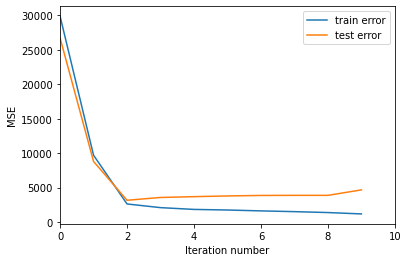

In [12]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [13]:
n_trees = 25
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [14]:
%%time
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 413
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5289
Wall time: 550 ms


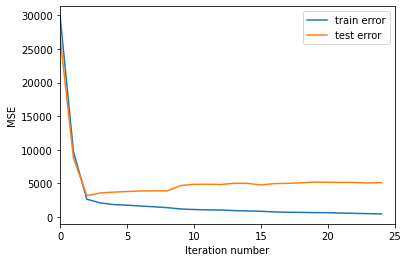

In [15]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [16]:
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [17]:
%%time
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993
Wall time: 543 ms


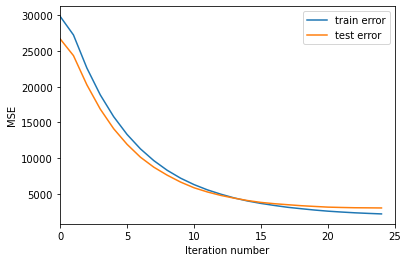

Wall time: 83.9 ms


In [18]:
%%time
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.005.

In [19]:
eta = 0.005

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [20]:
%%time
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.005 на тренировочной выборке: 19368
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.005 на тестовой выборке: 17331
Wall time: 549 ms


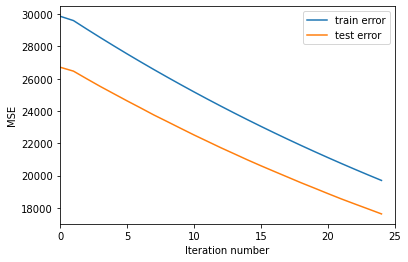

Wall time: 91.3 ms


In [21]:
%%time
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.05 и попробуем увеличить глубину деревьев

In [22]:
eta = 0.05
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [23]:
%%time
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 889
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3614
Wall time: 542 ms


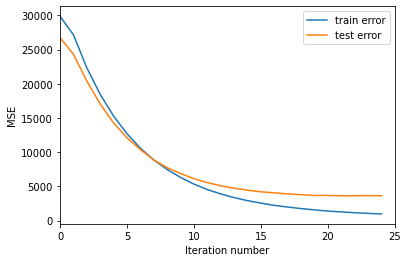

Wall time: 99.5 ms


In [24]:
%%time
get_error_plot(n_trees, train_errors, test_errors)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

## Домашнее задание

#### 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
#### Сделать выводы о зависимости ошибки от этих параметров. Подобрать оптимальные значения этих гиперпараметров.

Внесем изменения в формулы

In [30]:
%%time
n_trees = 25
coefs = [1] * n_trees
max_depth = 10
eta = 0.05
train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {i} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {i} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

Ошибка алгоритма из 25 деревьев глубиной 1     с шагом 0.05 на тренировочной выборке: 3325
Ошибка алгоритма из 25 деревьев глубиной 1     с шагом 0.05 на тестовой выборке: 3180
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 2692
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 2992
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 1456
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3147
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 889
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3614
Ошибка алгоритма из 25 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 513
Ошибка алгоритма из 25 дер

In [31]:
def depth_error_plot(max_depth, train_err, test_err):
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.legend(loc='upper right')
    plt.show()

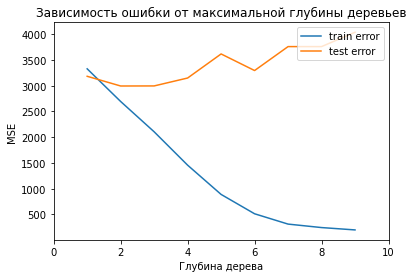

In [32]:
depth_error_plot(max_depth, train_errors_arr, test_errors_arr)

In [46]:
%%time
n_trees = 20
coefs = [1] * n_trees
max_depth = 3
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 7.1 s


In [47]:
%%time
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 20 деревьев глубиной 9     с шагом 0.05 на тренировочной выборке: 2556
Ошибка алгоритма из 20 деревьев глубиной 9     с шагом 0.05 на тестовой выборке: 3122
Wall time: 448 ms


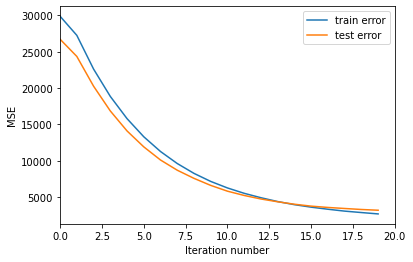

In [48]:
get_error_plot(n_trees, train_errors, test_errors)

__Вывод:__<br>
1) При увеличении глубины дерева ошибка снижается на тренирвочном сете, однако на тестовом она выходит на плато и затем начинает расти. Это скидетельствует о переобучении модели. Оптимальная глубина дерева в этом кейсе 2-3.<br>
2) Увеличение количества деревьев снижает ошибку на тренировочном и тестовом сетах. Однако с ростом количества деревьев более 15 (в данном кейсе) кривые ошибок трейн/ тест расходятся, что также свидетельствует о переобучении. Оптимальное количество деревьев в данном примере 20.

#### $^*$2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

Внесем изменения в функции:

In [49]:
def sgb_fit(subsample_value, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        
        # генерируем случайную подвыборку
        qtt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qtt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [57]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.05

In [64]:
%%time
trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(0.5, n_trees, 3, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 44.8 s


In [61]:
# def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
#     train_prediction = gb_predict(X_train, trees, coefs, eta)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

#     test_prediction = gb_predict(X_test, trees, coefs, eta)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [65]:
%%time
print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(train_errors_sgb[-1])}')

print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(test_errors_sgb[-1])}')

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 1648
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3203
Wall time: 0 ns


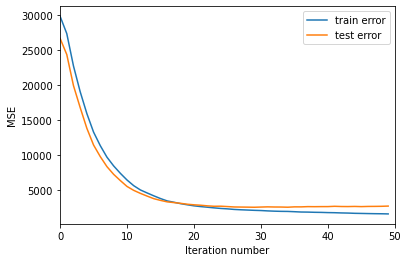

In [66]:
get_error_plot(n_trees, train_errors, test_errors)

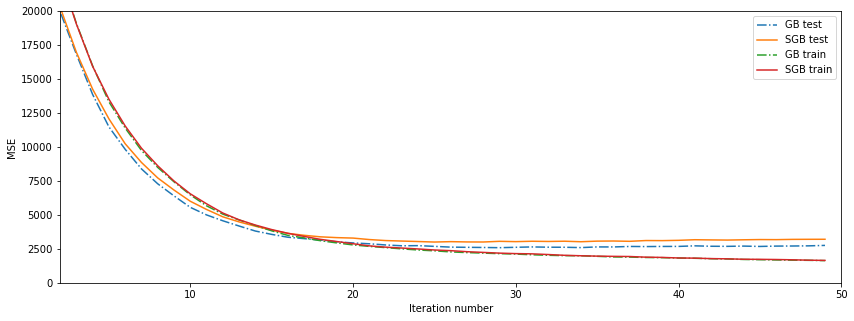

In [67]:
plt.figure(figsize=(14,5))
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(2, n_trees)
plt.ylim(0, 20000)
plt.plot(list(range(n_trees)), test_errors, '-.', label='GB test')
plt.plot(list(range(n_trees)), test_errors_sgb, label='SGB test')
plt.plot(list(range(n_trees)), train_errors, '-.', label='GB train')
plt.plot(list(range(n_trees)), train_errors_sgb, '-', label='SGB train')
plt.legend(loc='upper right');

#### $^*$3. Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)